### Title: Box Jenkins Methods- multi-variate

Author: Yiran Jing

Date: 11-10-2018

##### Summary

- Combine price variable alongside quantity demanded.

- Price dataset is stationary, with similar pattern of unit.

-**VAR model**


-**ARMAX model**


##### Insights

1. seasonality pattern is clear in price,  so seasonal ARMAX shall try, although seasonal ARMA in univariate case is unhelpful. but will double check


2. Does the increasing trend of price in the last whole year matter? Is possible structural break? shall test and see


3. Shall try Granger Causality Test bet unit and price for each product

In [2]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp

from time_series import pd_read_obs_csv # function used for read SA weather obs
import statsmodels.api as sm
import seaborn as sns
import datetime
import glob, os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


#### Create a new dataset with three products and prices. Similar process to Models_1 notebook.

In [3]:
data_transactions = pd.read_csv('../intellify_data/transactions.csv')


product_of_interest = [1111087398, 1111087395, 1111087396]
transactions_of_int = data_transactions[data_transactions.UPC.isin(product_of_interest)]

# Now we make the assumption of aggregating the dataset.
agg_trans = transactions_of_int.groupby(['WEEK_END_DATE','UPC']).sum().reset_index(['WEEK_END_DATE','UPC'])

prod_one = agg_trans[agg_trans.UPC == 1111087398] 
prod_two = agg_trans[agg_trans.UPC == 1111087395] 
prod_three = agg_trans[agg_trans.UPC == 1111087396] 

# Need to reset index to be able to add series together.
prod_two= prod_two.set_index(prod_one.index)
prod_three = prod_three.set_index(prod_one.index)

final_trans = pd.DataFrame()
final_trans["Prod_one"] = prod_one.UNITS
final_trans["Prod_one_price"] = prod_one.PRICE

final_trans["Prod_two"] = prod_two.UNITS
final_trans["Prod_two_price"] = prod_one.PRICE

final_trans["Prod_three"] = prod_three.UNITS
final_trans["Prod_three_price"] = prod_three.PRICE
final_trans["Date"] = prod_one.WEEK_END_DATE

# First, fix ordering of dataset by time series.
weekly_date = dates_from_str(final_trans.Date)

final_trans.Date = weekly_date
final_trans["Date"] = pd.to_datetime(final_trans.Date)
final_trans = final_trans.sort_values(by="Date")

# Dataset is weekly data, so get datetime version to later set as index. 
weekly_date = final_trans.Date

# Update index to get datetime index.
final_trans.index = pd.DatetimeIndex(weekly_date)
del final_trans["Date"]

train_data = final_trans[final_trans.index <= "2011-06-01"]
val_data = final_trans[final_trans.index > "2011-06-01"]

## Stationary of price

## P and Q selection

Stationary data already.

We run a selection process for AR(p) and MA(q).

### Method 1: Visualization selection  based on ACF/PACF.

Product Prod_one_price 


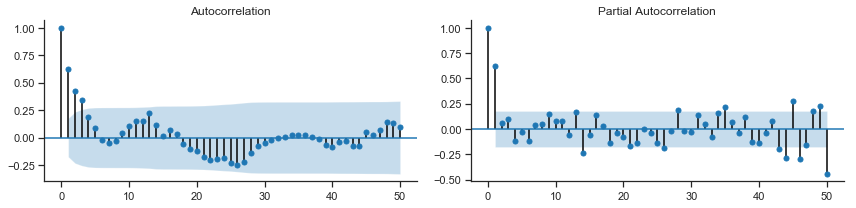

Product Prod_two_price 


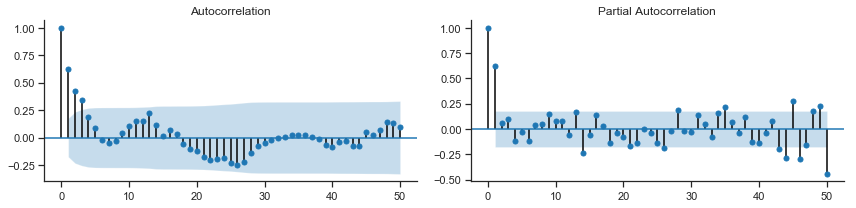

Product Prod_three_price 


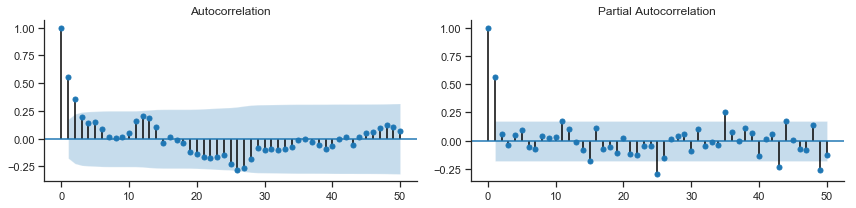

In [4]:
from time_series import data_time
from time_series import draw_acf_pacf

products = ["Prod_one", "Prod_two", "Prod_three"]
product_price = ["Prod_one_price", "Prod_two_price", "Prod_three_price"]

"""
Run ACF/PACF plot on each variable and check.
"""
draw_acf_pacf(product_price, train_data)

**Analysis of graphs for product 1-3 for the AR(p) model**

From the charts, they suggest that the number of lags p should be around 3-4. The rationale is that for the autocorrelation plots, the autocorrelation decrease exponentionally after the 4 period mark. However, for the partial autocorrelation, it cuts off to zero after lag 1.

Regardless, it appears that the AR(1) only is enough, but we still check other possible combinations.

##  VAR model
#### Testing Assumptions of model.

VAR need all time-series data are stationary. We already tested the variable units sold being stationary, now we test price variable.

Rejection of the null hypothesis suggests stationarity of the data. As P_value is close to zero, we have stationary data.

In [5]:
from statsmodels.tsa.stattools import adfuller

product_price = ["Prod_one_price", "Prod_two_price", "Prod_three_price"]

"""
Run ADF test on the price of each product.
"""

for prod in products:
    print("P-value for {} is {:.5f}".format(prod, adfuller((final_trans[prod]))[1]))

P-value for Prod_one is 0.00000
P-value for Prod_two is 0.00000
P-value for Prod_three is 0.00000


Price is also stationary.

#### Looking at price data more closely.

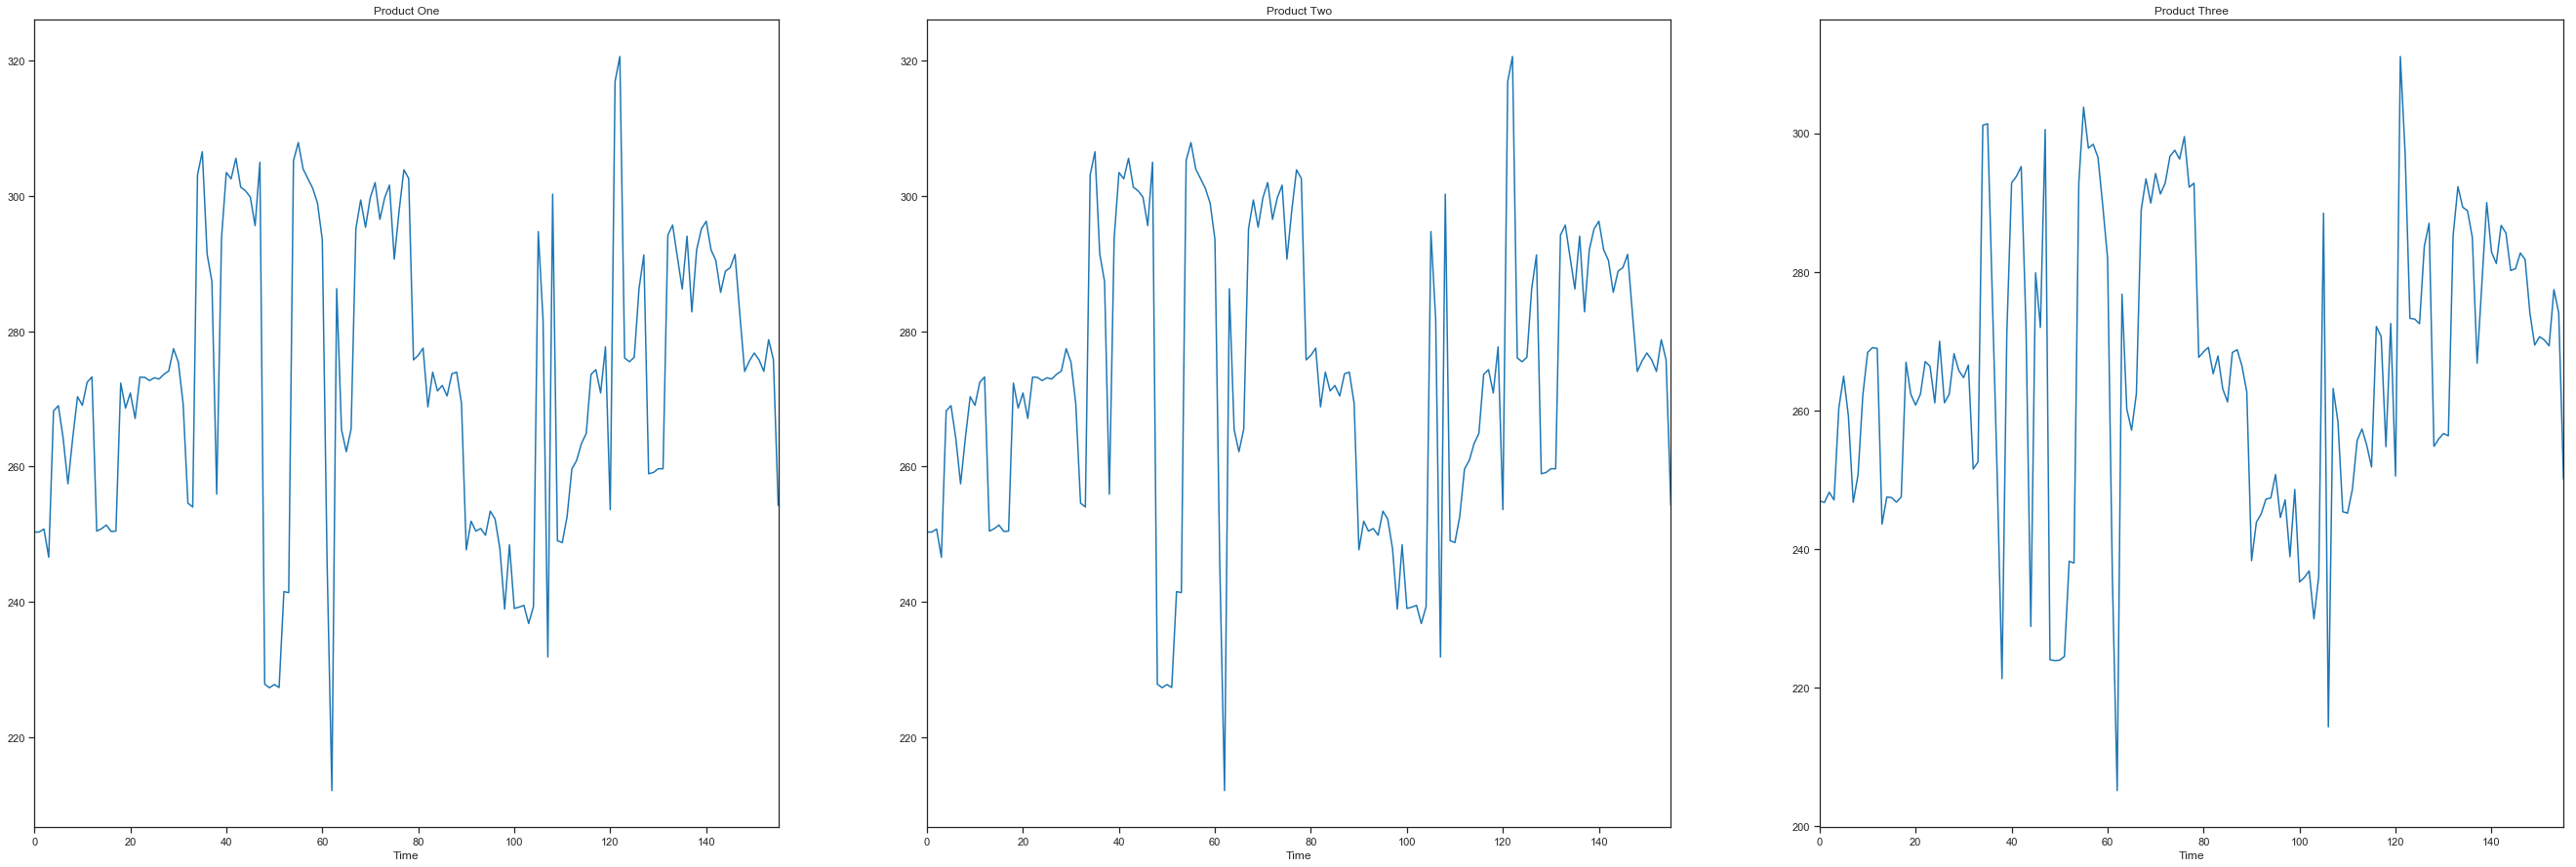

In [12]:
from time_series import draw_time_series
"""
Plot origin Price data out.
"""
draw_time_series(final_trans, product_price)

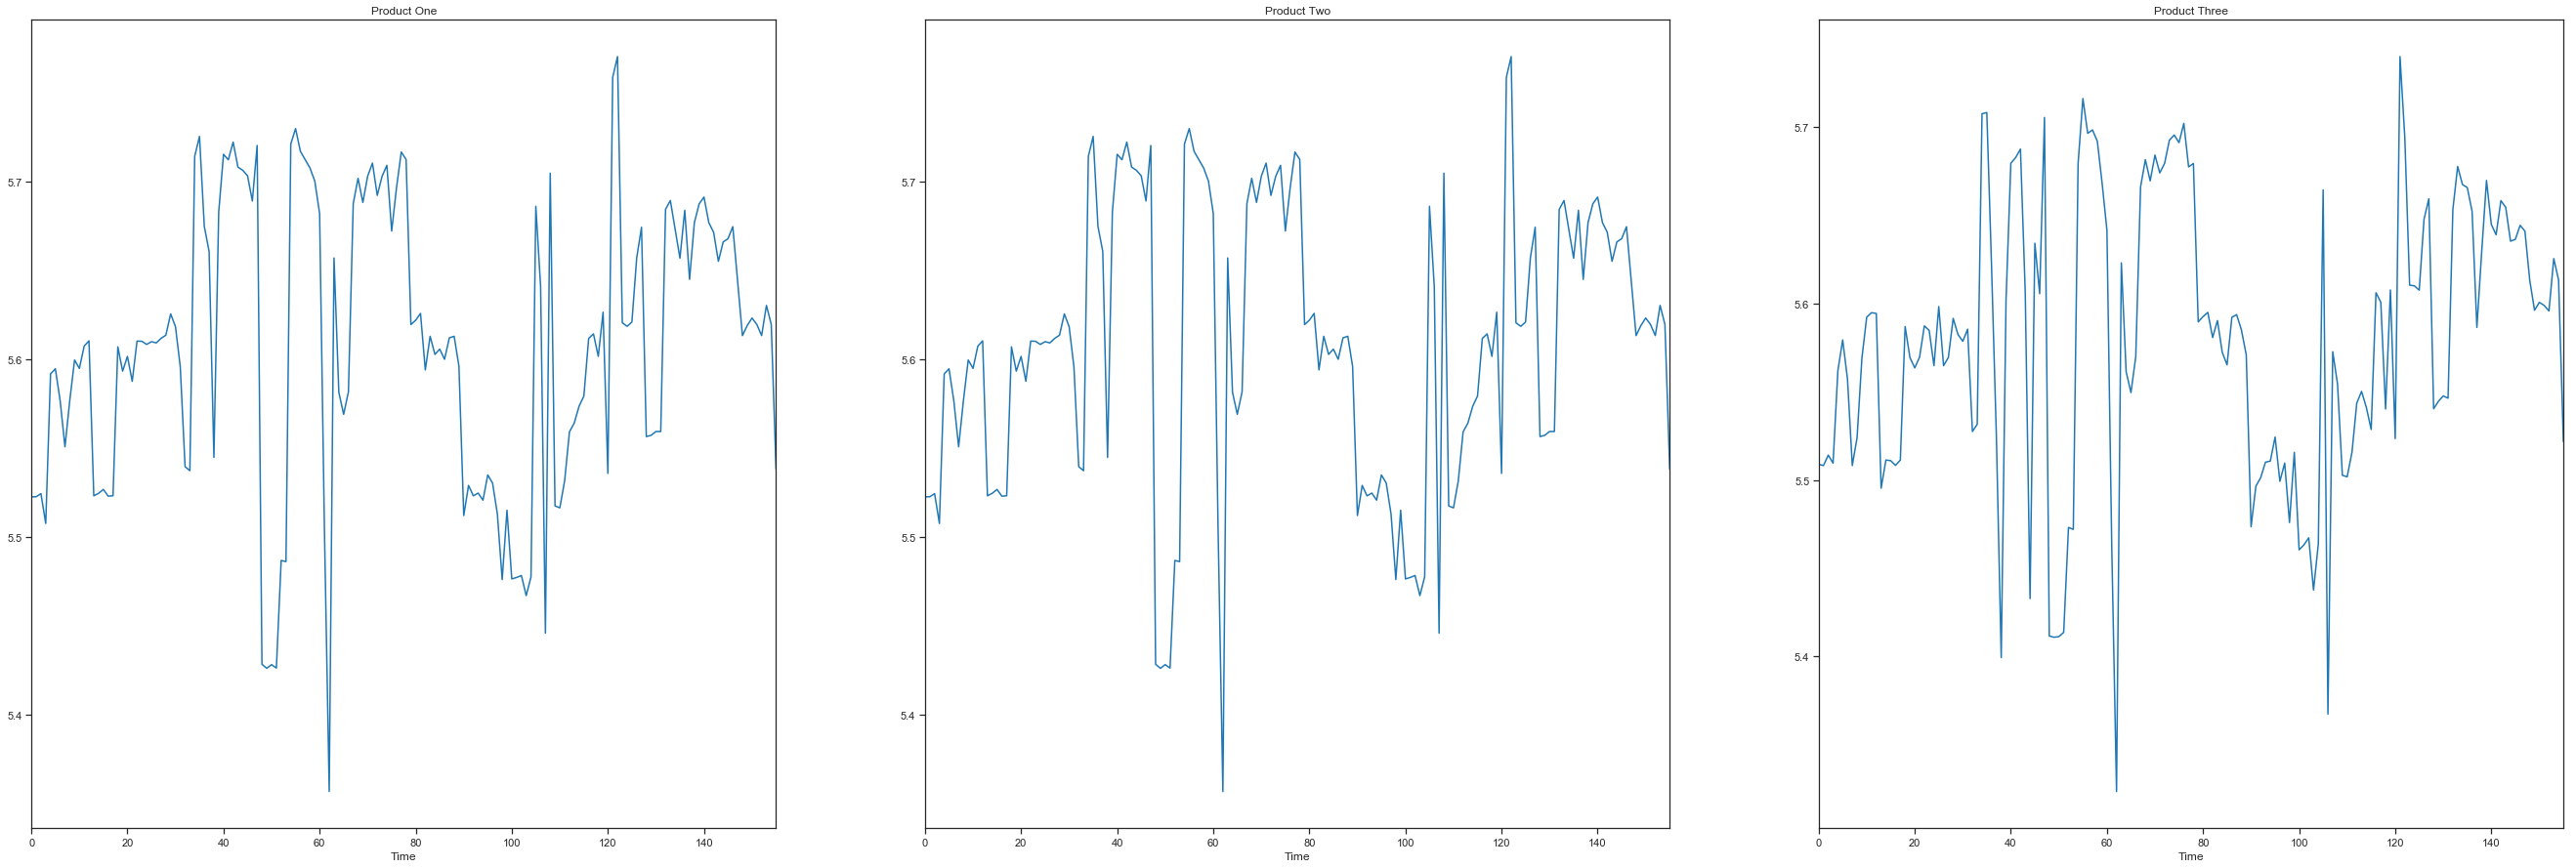

In [13]:
from time_series import draw_log_time_series
"""
Plot log_Price data out.

still cannot steable variance, so just keep orgin price in modelling.
"""
draw_log_time_series(final_trans, product_price)

## time decomposition

-**Trend**: Seems that there is a clear increasing trend of price during 2011.

-**Seasonality**: Clear seasonality pattern, so we shall try to capture it.

-**White noise**: No white noise remaining.

<Figure size 432x288 with 0 Axes>

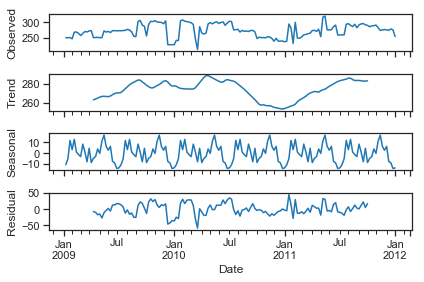

<Figure size 432x288 with 0 Axes>

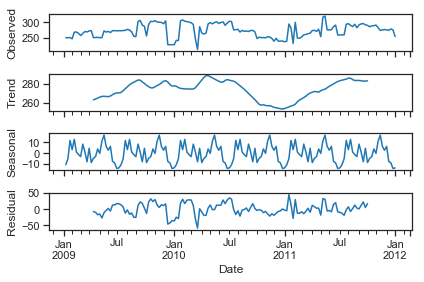

<Figure size 432x288 with 0 Axes>

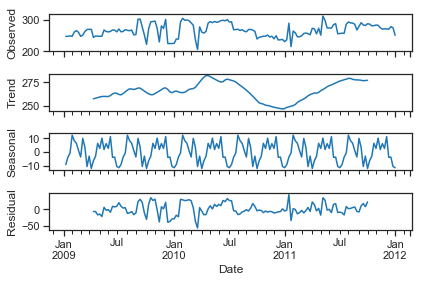

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

"""
Plot differenced data out.
"""
#fig, axes = plt.subplots(nrows=1, ncols=3)

#plt.subplot(1,3,1)
res = seasonal_decompose(final_trans["Prod_one_price"], freq=26)
fig = plt.figure()  
fig = res.plot()
#plt.title("Product One")

#plt.subplot(1,3,2)
res = seasonal_decompose(final_trans["Prod_two_price"], freq=26)
fig = plt.figure()  
fig = res.plot()
#plt.title("Product Two")

#plt.subplot(1,3,3)
res = seasonal_decompose(final_trans["Prod_three_price"], freq=26)
fig = plt.figure()  
#plt.title("Product Three")
fig = res.plot()


## VAR Model.

In [15]:
col_list = ['Prod_one', 'Prod_one_price', 'Prod_two_price', 'Prod_three_price']
final_trans = final_trans[col_list]

In [17]:
from statsmodels.tsa.api import VAR
# Fit the object on the dataset.
model = VAR(train_data)
model = model.fit(2)

# Since VAR(1), need to pass in last 3 values of training set.
var_pred = model.forecast(train_data.values[-2:], len(val_data))

In [18]:
"""
Checking results of VAR(2) prediction.
"""

products = ["Prod_one", "Prod_two", "Prod_three"]

results = {}
# Loop over a forecast product
for prod, prod_num in zip(products, range(0,3)):
    # Compute metric for each product.
    diff = []
    
    for time in range(0, len(val_data[prod])):

        # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(var_pred[time][prod_num] - val_data[prod].iloc[time])/val_data[prod].iloc[time]))

    # Add the result to dictionary.
    results.update({prod: sum(diff)/len(diff)})

In [19]:
pd.DataFrame(list(results.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,38.640629
1,Prod_two,60.097784
2,Prod_three,43.241826


Terrible performance.

## Fitting a non-seasonal ARMA (p,q)

**Model selection range** 
- p from 0-2, q from 0-2.

**Based on AIC selection** 
- AR(1) is simplest and best.

**Based on MAPE** 
- AR(1) still
****

In [20]:
"""
BenchMark is AR(1)
Firstly, we do AIC to for ARMA selection
p from 0-2, q from 0-2.
"""
y = data_time(train_data,'Prod_one')
arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit()
#print(arma_benchmark.aic)

In [21]:
def aic_selection(sarima_benchmark, p, q): # initial value of p, q (benchmark)
    '''
    ARMA(p, q) model selection. p from 0-2, and q from 0-2. d=0
    '''
    try:
        warnings.filterwarnings('ignore')
        best_score=sarima_benchmark.aic
        best_model=sarima_benchmark
        x1= range(3) # p from 0-2
        x3= range(3) # q from 0-2
        for i in x1:
            j=0
            for k in x3:
                    model=sm.tsa.statespace.SARIMAX(y,  order=(i, j, k)).fit()
                    score=model.aic
                    if (score<best_score):
                        best_score=model.aic
                        p = i;q = k
    except ValueError:
        pass
    return (p, q, best_score)

In [22]:
'''
select best ARMA model based on AIC, MAPE for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark,1, 0)
    results.update({prod: [p1, q1,best_score1.round(2)]})

In [23]:
pd.DataFrame(list(results.items()), columns=['Product','AIC'])

,Product,AIC
0,Prod_one,"[1, 0, 1912.13]"
1,Prod_two,"[1, 0, 1840.05]"
2,Prod_three,"[1, 2, 1856.3]"


## Exponential smoothing

it can be written as ARIMA(0,1,1)

if select based on AIC, ES has slighly smaller AIC than ARMA(1, 0, 0) for three products, but much bigger MAPE than AR(1). 

So AR(1) shall be overall a better choice

In [29]:
'''
Compare ES model with ARMA result based on AIC for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(0, 1, 1)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark, 0, 1)
    
    results.update({prod: [p1, q1,best_score1.round(2)]})

In [30]:
"""
Checking results of Exponential smoothing prediction.
"""

products = ["Prod_one", "Prod_two", "Prod_three"]

results = {}
# Loop over a forecast product
for prod in products:
    # Compute metric for each product.
    diff = []
    train_data[prod] = train_data[prod].astype('float64')
    # Fit and predict AR(1) model.
    ar_mod = ARIMA(train_data[prod], order=(0,1,1)).fit()
    var_pred = ar_mod.predict(start=val_data.index[0], end=val_data.index[-1])
    
    for time in range(0, len(val_data[prod])):
        # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(var_pred[time] - val_data[prod].iloc[time])/val_data[prod].iloc[time]))

    # Add the result to dictionary.
    results.update({prod: sum(diff)/len(diff)}) 

In [31]:
pd.DataFrame(list(results.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,101.255797
1,Prod_two,101.088261
2,Prod_three,101.252627


Terrible performance in general with this model.